Processing temperature: 1.5 K, file: ../Inputs/prod/kalj_T0.5_n360_v300_prod_10000000_1.unwrap.xyz
Temperature 1.5 K, first 10 MSD values: [-2.09689056e-12  2.13268768e+00  2.41496668e+00  2.62461611e+00
  2.79320399e+00  2.97558808e+00  3.16293806e+00  3.31090004e+00
  3.45903671e+00  3.58857995e+00]
At temperature 1.5 K, MSD first crosses 1 at time 1.000 seconds.
Processing temperature: 1.0 K, file: ../Inputs/prod/kalj_T0.8_n360_v300_prod_150000_1.unwrap.xyz
Temperature 1.0 K, first 10 MSD values: [-3.15796771e-12  1.44246210e+00  1.91204869e+00  2.15645481e+00
  2.29480759e+00  2.41205785e+00  2.52453003e+00  2.60739202e+00
  2.66356105e+00  2.74327281e+00]
At temperature 1.0 K, MSD first crosses 1 at time 1.000 seconds.
Processing temperature: 0.9 K, file: ../Inputs/prod/kalj_T1_n360_v300_prod_50000_1.unwrap.xyz
Temperature 0.9 K, first 10 MSD values: [-3.72134915e-12  7.27475352e-01  1.27297034e+00  1.63098253e+00
  1.83069450e+00  1.98260038e+00  2.11853597e+00  2.22815702e+00
  

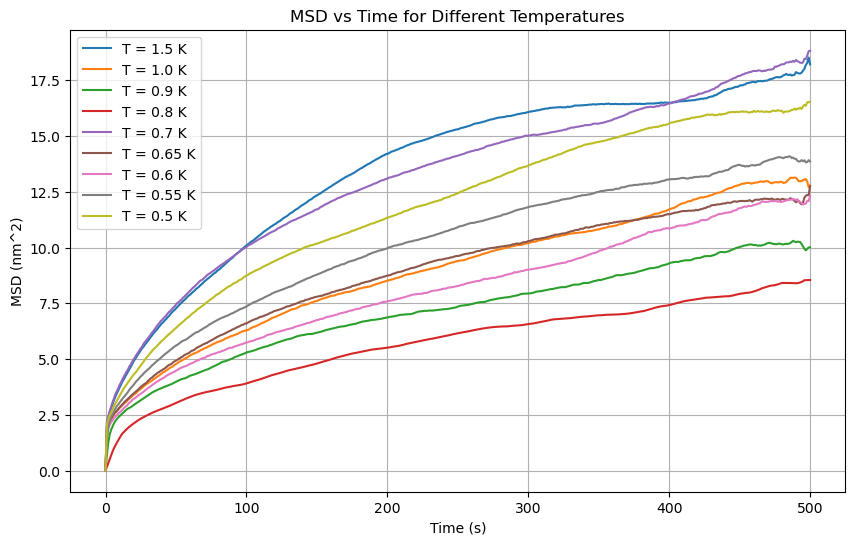

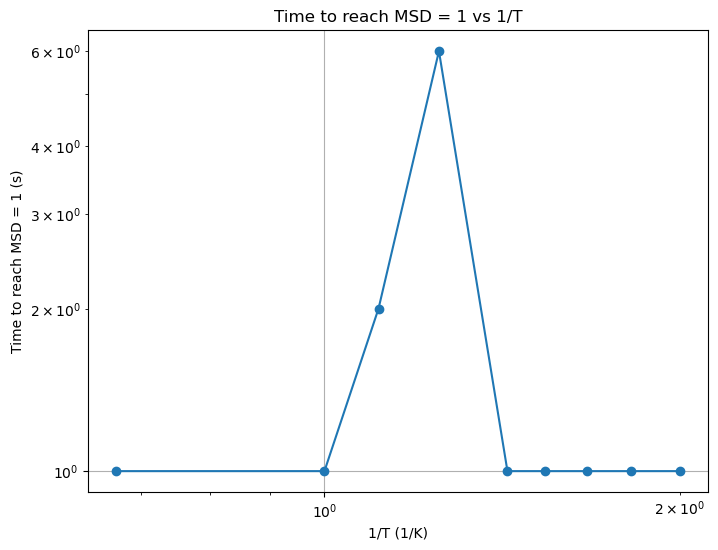

In [4]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import msd
import matplotlib.pyplot as plt
import glob

# Load trajectory files and topology file
trajectory_files = glob.glob("../Inputs/prod/*kalj*.xyz")
topology_file = glob.glob("../Inputs/equil/*kalj*.lammpstrj")[0]

# Check if the number of files matches the number of temperatures
temperatures = [1.5, 1.0, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.4750]

# Load the universe with the topology and trajectory, specifying the topology format
universe = mda.Universe(topology_file, trajectory_files, topology_format='LAMMPSDUMP')
dt = 0.001  # Time step in seconds

# Lists to store results
times_to_reach_msd_1 = []
inverse_temperatures = [1 / temp for temp in temperatures]

# Plotting setup for individual MSD curves
plt.figure(figsize=(10, 6))

# Loop through the temperatures and trajectory files to calculate MSD for each
for idx, (temp, traj_file) in enumerate(zip(temperatures, trajectory_files)):
    print(f"Processing temperature: {temp} K, file: {traj_file}")
    
    # Reload universe for each file (ensure independent MSD calculation)
    universe = mda.Universe(topology_file, traj_file, topology_format='LAMMPSDUMP')
    selection_str = 'all'  # Adjust selection as needed
    selection = universe.select_atoms(selection_str)  # Get the AtomGroup

    # Perform MSD calculation
    msd_analysis = msd.EinsteinMSD(selection, dt=dt)
    msd_analysis.run()

    # Access the timeseries data for MSD
    msd_values = msd_analysis.results['timeseries']
    times = msd_analysis.times

    # Debug: Print first 10 MSD values for inspection
    print(f"Temperature {temp} K, first 10 MSD values:", msd_values[:10])

    # Plot individual MSD curves to verify differences
    plt.plot(times, msd_values, label=f'T = {temp} K')

    # Find the time when MSD first crosses 1
    time_at_msd_1 = None
    for i, msd_value in enumerate(msd_values):
        if msd_value >= 1:
            time_at_msd_1 = times[i]
            print(f"At temperature {temp} K, MSD first crosses 1 at time {time_at_msd_1:.3f} seconds.")
            break

    # Append the time to the list (could be None if not found)
    times_to_reach_msd_1.append(time_at_msd_1)

# Show individual MSD curves for each temperature
plt.xlabel('Time (s)')
plt.ylabel('MSD (nm^2)')
plt.title('MSD vs Time for Different Temperatures')
plt.legend()
plt.grid(True)
plt.show()

# Ensure times_to_reach_msd_1 and inverse_temperatures are consistent
valid_data = [(inv_temp, time) for inv_temp, time in zip(inverse_temperatures, times_to_reach_msd_1) if time is not None]
inverse_temperatures_filtered, times_to_reach_msd_1_filtered = zip(*valid_data)

# Create a log-log plot of time to reach MSD=1 vs 1/T
plt.figure(figsize=(8, 6))
plt.loglog(inverse_temperatures_filtered, times_to_reach_msd_1_filtered, marker='o')
plt.xlabel('1/T (1/K)')
plt.ylabel('Time to reach MSD = 1 (s)')
plt.title('Time to reach MSD = 1 vs 1/T')
plt.grid(True)
plt.show()
